# Appetizer: Textbook Correlation Power Analysis (CPA)

In this section, we dig a bit more into side-channel analysis by implementing a more advanced attack. The aim of the first exercise is to carry out the example attack presented in Chapter 1 of the book, commonly known as CPA. next, we will dig a bit more into the impact of noise that we briefly encountered in the previous session.




## Correlation Power Analysis step-by-step
As a reminder, this attack is a method that exploits the correlation between the practical measurements collected from an implementation execution and a model of these measurements. In order to perform a CPA, you generally use an a-priori leakage model and assumes that the power consumption of the target device is linearly correlated with it. 

To exploit such a model, Pearson’s correlation coefficient is a natural candidate. This statistic measures how well the leakages can be predicted by a given linear model. The underlying idea is that the subkey hypothesis predicting the leakages best should be the correct one. 

The following exercises will guide you through implementing a CPA from scratch.

### Step 1: Computation of the correlation
The first step of this exercise is to implement the computation of the correlation between measurements and their model, as defined below:

$$r_{xy} = \dfrac{\mathsf{cov(X,Y)}}{\sigma_X \sigma_Y}=\dfrac{ \mathsf{\hat E}(X^c Y^c)}{\sqrt{\mathsf{\hat V}(X)\mathsf{\hat V}(Y)}}$$

where $\mathsf{\hat E}$ and $\mathsf{\hat V}$ denote respectively the empirical mean and variance, $ X $ represents the leakage values, and $ Y $ represents the model values (e.g., the Hamming weight of the hypothetically manipulated values), while $X^c = X - \mathsf{\hat E}(X)$ (and similarly for $Y^c$).

Without knowing a priori exactly where the interesting operations are located in the traces, we have to compute the correlation that exists between the model associated to the target intermediate state and all the time samples in the traces. Although this can be done in a for iteration loop over all sample location in a trace, we invite you to try to carry out the operations in the form of vector/matrix operations in order to obtain good performance (This advice applies to the rest of the training too). 

You first task in order to compute the correlation is to compute the covariance by yourself. For that, we invite you to implement the following function:

- *hint: NumPy [mean](https://numpy.org/doc/2.2/reference/generated/numpy.mean.html) and [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) may be useful*

In [1]:
import numpy as np

#TODO implement this function
def covariance(l, m):
    """
    Compute the covariance metric between the leakage trace 
    and the modelled leakage values, for each independant time index of the traces.
    
    l: the raw traces, as an NumPy array of shape (ntraces, nsamples)
    m: the modelled values, as a NumPy array of shape (ntraces, nsamples)

    Return: the covariance as the NumPy array 'cov' of shape (nsamples,)
    such that cov[i] is the covariance between l[:,i] and m[:]
    """
    ###ANSWER_START
    lc = l - np.mean(l, axis=0)
    mc = m - np.mean(m, axis=0)
    return np.mean(lc*mc, axis=0)
    ###ANSWER_STOP
    

You can verify your implementation here:

In [2]:
from utils_scale import test_scale
test_scale.test_covariance(covariance)

Good job! Your implementation seems correct :)


The next step is to compute the standard deviation of the different variable. To do so, you asked to implement the following function

- *hint: see NumPy [std](https://numpy.org/doc/stable/reference/generated/numpy.std.html)*

In [3]:
import numpy as np

#TODO implement this function
def std(v):
    """
    Compute the column-wise standard deviation, where a 
    single column contains different outcomes of a single random variable. 
    
    v: the variables, as an NumPy array of shape (nexec, nvars)

    Return: the column-wise standard deviation as the NumPy array 'std' of shape (nvars,) 
    """
    ###ANSWER_START
    return np.std(v, axis=0)
    ###ANSWER_STOP

You can verify your implementation here:

In [4]:
from utils_scale import test_scale
test_scale.test_std(std)

Good job! Your implementation seems correct :)


As a final step, you are invited to use the function `covariance` and `std` that you just implemented in order to implement the function `pearson_corr` that computes the Pearson Correlation! 

In [5]:
def pearson_corr(l, m):
    """
    Compute the pearson column-wise correlation between the 
    leakage trace and their model. 

    l: the leakage matrix of shape (ntraces, nsamples)
    m: the model matrix of shape (ntraces, nsamples)

    Return: the column-wise correlation between the matrices 'l' and 'm', as the NumPy array 'corr' of shape (nsamples,)
    such that corr[i] is the correlation between l[:,i] and m[:] 
    """
    ###ANSWER_START
    cov = covariance(l,m)
    std_l = std(l)
    std_m = std(m)
    return cov/(std_l*std_m)
    ###ANSWER_STOP

You can verify your implementation here:

In [6]:
from utils_scale import test_scale
test_scale.test_pearson_corr(pearson_corr)

Good job! Your implementation seems correct :)


### Step 2: Model computation.

A simple model proposed is the Hamming Weight model, which represents the leakage as the sum of the bits set to '1' for the values taken by a specific intermediate variable manipulated by the implementation (e.g., the values at the output of the S-box). This hypothesis is commonly found in the literature and is a reasonable approximation observed in practice for CMOS technology implementations . Don't hesitate to go back to the previous session in order to compare the trace behavior associated to different value of a single Sbox output if you want to see for yourself!

To make things easier for you, we've compiled the hamming weigh associated with the 256 possible byte values in the form of a NumPy array. The following code shows you how to use it:

In [7]:
from utils_scale.utils_aes import HW

# Similarly to the 'Sbox' array that you used before, 'HW' is an array
# such that Sbox[i] is the Hamming Weight of the byte value 'b'.

# Hamming Weight example
HW_0xAA = HW[0xAA]
HW_0x00 = HW[0x00]
HW_0xFF = HW[0xFF]
assert HW_0xAA == 4, "The HW 0xAA must be equal to 4"
assert HW_0x00 == 0, "The HW 0xAA must be equal to 0"
assert HW_0xFF == 8, "The HW 0xAA must be equal to 8"
print("You know now how to use the 'HW' array :)")

You know now how to use the 'HW' array :)


Now that we've chosen which model to use, we need to define which intermediate variable we want to target. To continue with what you've already had a chance to manipulate, we propose to model the leakage associated with Sbox output values. To keep it simple, we will focus on a 8-bit state only first (out of 128). 

Your next goal is to compute the model for the byte we target. To do so, you have to implement the followign function

In [8]:
from utils_scale.utils_aes import Sbox, HW

#TODO implement this function
def HW_sbox_output(pts, ks):
    """
    Compute the Hamming Weight of the single byte resulting from the Sbox operation, for each execution.

    pts: the plaintext bytes values for the targeted byte index, as an array of shape (nexec, ) and of type np.uint8
    ks: the key bytes values for the targeted byte index, as an array of shape (nexec,) and if type np.uint8

    Returns: the Hamming weigh of the value at the output of the Sbox, as an array of shape (nexec,)
    """
    ###ANSWER_START
    return HW[Sbox[pts ^ ks]]
    ###ANSWER_STOP

You can verify you function here:

In [9]:
from utils_scale import test_scale
test_scale.test_HW_sbox_output(HW_sbox_output)

Good job! Your implementation seems correct :)


### Step 3: Compute the correlation with real measurements

Things are starting to get interesting: your next goal is to compute the correlation you get for real traces! To this purpose, you have to implement the following function

- *hint: you are targeting a single intermediate state, but you have to provide a model for each time samples.*
- *hint2: see [tile](cpa_out_sbox_profiled)*

In [10]:
# TODO: implement this function
def corr_HW_traces_outSB(traces, pts, ks):
    """
    Compute the correlation between the traces and the HW model of a single Sbox output, for every time samples.

    traces: the traces, as an array of shape (nexec, nsamples)
    pts: the plaintext byte value targeted, as an array of shape (nexec,)
    ks: the key byte value target, as an array of shape (nexec,)

    Return, the correlation, as an array of shape (nsamples, )
    """
    ###ANSWER_START
    # Compute the model
    m = HW_sbox_output(pts, ks)
    # Compute the correlation
    return pearson_corr(traces, np.tile(m[:,np.newaxis],(1,traces.shape[1])))
    ###ANSWER_STOP

You can verify your implementation here:

In [11]:
from utils_scale import test_scale

test_scale.test_corr_HW_traces_outSB(corr_HW_traces_outSB)

Good job! Your implementation seems correct :)


In order to gain some intuition about the correlation you compute. Assuming the hypothesis holds, a correlation peak should appear at the time sample corresponding to the moment when the targeted intermediate value is actually manipulated by the device. See for yourself with the following template that allows you to plot the correlation computed for a specific byte index (you can tune which one by adjusting the variable `bindex`). Is it coherent with what you observed in the previous session? 

Alternatively, try to used wrong intermediate variables values used to compute the model (e.g., set all the plaintext bytes to 0). 
 What do you observe in such a situation? How do you explain it? 

Maximum of correlation (0.817) spotted at time sample index 3386.


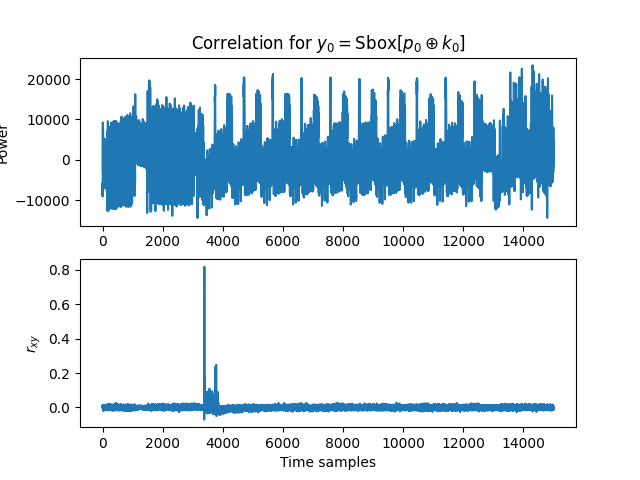

In [12]:
from utils_scale import utils_plot, utils_obs
%matplotlib widget
import matplotlib.pyplot as plt

# TODO: try to see what happens when you change this parameter
# Targeted byte index
bindex = 0

# Load the dataset with all random inputs
dataset = utils_obs.load_dataset_all_random()

# Compute the correlation associated to the targeted byte index
corr = corr_HW_traces_outSB(
    dataset['traces'], 
    dataset['pts'][:,bindex], # TODO, modify HERE 
    dataset['ks'][:, bindex]
)

# Display the correlation, together with an examplary trace
utils_plot.display_correlation(corr, dataset['traces'][0,:], bindex)

### Step 4: Attacking a single key byte.

At last, here is what you've probably been waiting for: implementing the attack in itself! In the context of a practical attack, the adversary is considered to have access to a set of traces as well as the associated plaintext that have been used. His goal is the recover the value of the fixed (and unknown) key used to process the plaintexts. 

The most common CPA exploits leakages from intermediate values manipulated by the cryptographic implementation, whose value depends on both the key and known plaintexts (see KIS sensitive variable, Definition 3 in the book). As shown in the previous step, the values manipulated after the substitution layer appear to be a good target because of the significant levels of correlation that they enable. The attack underlying idea is that the subkey hypothesis that predicts the leakages best should be the correct one. Put in another way, the correlation computed should be maximum for the correct subkey, and it should be significantly lower for the others (as shown with the `mask` parameter above).

However, making hypotheses about all the key bytes simultaneously can be computationally difficult: it would imply to enumerate $2^{128}$ different hypotheses, which is far from reachable in practice nowadays. For this reason, a commonly used strategy is to follow a divide and conquer approach. The main idea of the latter is to attack (small) independent sub-parts of the key independently, and combine the results obtained together. 

In this exercise, we propose to follow such a strategy by targeting each byte of the key sequentially, and to combine the results obtained for the 16 independant attacks together to recover the full 128-bit key. To this end, the basic methodology can be summarized as follows:


+ For each key byte index $i$:
    + For each key candidate $k_{i}^* \in [0; 255]$:
        + Predict the intermediate values that are expected to be manipulated at each execution under the hypothesis that $k_{i}^*$ is used:
            + $x_{i} = p_i \oplus k_{i}^*$ when using the S-box input
            + $y_i = \text{Sbox}(x_i)$ when using the S-box output
        + Compute the Hamming Weight of the intermediate values, considered as the leakage model.
        + Compute the correlation between the model and the practical measurements provided.
    + Keep the value $k_{i}^*$ maximising the correlation as the predicted correct key byte.
 
To put this methodology into practice, we first ask you to perform the CPA using the leakage of the Sboxes output against a single byte by implementing the function `cpa_byte_out_sbox`. 

- *hint: see [zeros](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html#numpy.zeros), [abs](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html), [max](https://numpy.org/doc/stable/user/basics.broadcasting.html), [argsort](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html#numpy-argsort), and [flip](https://numpy.org/doc/stable/reference/generated/numpy.flip.html#numpy.flip) from NumPy*
- *hint2: Do you have to consider the complete traces in your computations? From what you saw in the previous exercice, you may want keep only a smaller part of these in order to speed up your computations.*

In [13]:
import numpy as np
#TODO implement this function
def cpa_byte_out_sbox(traces, pts):
    """ 
    Perform a CPA against a single key byte.

    traces: the traces, as an array of shape (nexec, nsamples)
    pts: the plaintext bytes associated to the target key byte, as an arrya of shape (nexec, )

    Returns: a NumPy array of shape (256,), with the 256 key bytes candidates ordered 
    from the highest correlation to the less one (the candidat.
    """
    ###ANSWER_START
    maxcorr = np.zeros(256)
    for k in range(256):
        maxcorr[k] = np.max(np.abs(corr_HW_traces_outSB(traces, pts, np.ones(len(pts), dtype=np.uint8)*k)))
    return np.flip(np.argsort(maxcorr))
    ###ANSWER_STOP

To verify your implementation, lets try to perform the attack against a real dataset! In particular, you can use the following template in order to run your attack against a fixed-key dataset. You can define the amount of traces used to perform the attack (i.e., the *attack data complexity*) by setting the value of the variable `q_a`. How is this parameter affecting the success of you attack? What is the minimal amount of traces required to recover the key byte? Is it the same for every byte index? 

- *NB: depending on your implementation, running the attack may take time to proceed when too much time are used.*

In [14]:
from utils_scale import utils_files

# Load the fixed-key dataset
dataset = utils_files.load_dataset(utils_files.VALIDATION_DS[0])

# TODO: modify this parameter
q_a = 100

# TODO: modify this parameter
bindex = 0 

# Run the attack
k_guesses = cpa_byte_out_sbox(dataset["traces"][:q_a,:], dataset["pts"][:q_a,bindex])

if k_guesses[0]==dataset['ks'][0,bindex]:
    print(f"Nice job! The proper key byte ({dataset['ks'][0,bindex]}) has been recovered :) ")
else:
    print(f"The value {k_guesses[0]} has been recovered instead of {dataset['ks'][0,bindex]} :(")

Nice job! The proper key byte (66) has been recovered :) 


### Step 5: Attacking a full key

As the cherry on the top, the final step is to perform the CPA against the full key, by implementing the function `complete_cpa_out_sbox` defined next. How many traces are required to recover the full key? 

In [15]:
# TODO: implement this function
def complete_cpa_out_sbox(traces, pts):
    """ 
    Perform a CPA against the full key.

    traces: the traces, as an array of shape (nexec, nsamples)
    pts: the plaintexts used, as an array of shape (nexec, 16)

    Returns: a NumPy array of shape (16,), with the best key candidate 
    """
    ###ANSWER_START
    return np.array([cpa_byte_out_sbox(traces, pts[:,i])[0] for i in range(16)])
    ###ANSWER_STOP

Run the full attack next:

In [16]:
from utils_scale import utils_files

# Trace cropping window to use
# NB: you may want to change that
start=0
end=15000
###ANSWER_START
start=2500
end=4000
###ANSWER_END

# Load the fixed-key dataset
dataset = utils_files.load_dataset(utils_files.VALIDATION_DS[0], cropping=[start,end])

# TODO: modify this parameter
q_a = 10
###ANSWER_START
q_a = 60
###ANSWER_END

# Run the attack
k_guess = k_guess = complete_cpa_out_sbox(dataset['traces'][:q_a], dataset['pts'][:q_a])

# Verify results:
correct_key = dataset['ks'][0,:]
for i, (e,ce) in enumerate(zip(k_guess,correct_key)):
    print(f"k[{i}] recovered is {e} (must be {ce}) -> {'SUCCESS' if e==ce else 'FAIL'}")

k[0] recovered is 66 (must be 66) -> SUCCESS
k[1] recovered is 26 (must be 26) -> SUCCESS
k[2] recovered is 190 (must be 190) -> SUCCESS
k[3] recovered is 127 (must be 127) -> SUCCESS
k[4] recovered is 152 (must be 152) -> SUCCESS
k[5] recovered is 103 (must be 103) -> SUCCESS
k[6] recovered is 41 (must be 41) -> SUCCESS
k[7] recovered is 47 (must be 47) -> SUCCESS
k[8] recovered is 14 (must be 14) -> SUCCESS
k[9] recovered is 30 (must be 30) -> SUCCESS
k[10] recovered is 175 (must be 175) -> SUCCESS
k[11] recovered is 133 (must be 133) -> SUCCESS
k[12] recovered is 61 (must be 61) -> SUCCESS
k[13] recovered is 48 (must be 48) -> SUCCESS
k[14] recovered is 12 (must be 12) -> SUCCESS
k[15] recovered is 130 (must be 130) -> SUCCESS


### CPA: An efficient turnkey tool with SCALib

Never heard about [SCALib](https://scalib.readthedocs.io/en/latest/index.html#)? The Side-Channel Analysis Library (SCALib) is a Python package that contains state-of-the-art tools for side-channel evaluation, focusing on efficiency and easy interface. It turns out to contain an implementation of [CPA](https://scalib.readthedocs.io/en/latest/source/api/scalib.attacks.Cpa.html#scalib.attacks.Cpa). 

We provide next the implmentation of the function `scalib_complete_cpa_out_sbox` that is an alternative to `complete_cpa_out_sbox` relying on SCALib! As a final exercice, try to understand how it works and compare the performances achieved between the functions `complete_cpa_out_sbox` and `scalib_complete_cpa_out_sbox`. You should normally see a significative speed improvement when processing higher number of traces :) 

- *NB: these two functions are available from `utils_scale.utils_cpa`*

In [17]:
from utils_scale.utils_aes import HW
from scalib.attacks import Cpa
import numpy as np

def scalib_corr_traces(traces, pts, models):
    """ 
    Compute the HW correlation, for several variables.

    traces: the traces, as an array of shape (nexec, nsamples)
    pts: the plaintexts used, as an array of shape (nexec, nvars)
    models: array of shape (nvars, nclasses, nsamples), 

    Returns: a NumPy array of shape (nvars,nclasses,nsamples), with the correlation values associated to each of the independent subkey candidate
    """
    cpa = Cpa(nc=models.shape[1], kind=Cpa.Xor)
    cpa.fit_u(np.round(traces).astype(np.int16),pts.astype(np.uint16))
    return cpa.get_correlation(models)

def model_HW_outSB(nvars, nsamples):
    """
    Compute the HW models for SCALib CPA, for all the Sboxes output variables.

    To speed up computation, the intermediate considered in SCALib CPA is the result of an configurable 
    operation (e.g. XOR) between the key and the states provided during the fitting phase. 
    In our case, the class label of the models are the one correspondign to the result of the XOR between 
    the plaintext byte and the candidate key byte, or the input of the Sbox. 
    
    """
    return np.tile(HW[Sbox][np.newaxis,:,np.newaxis], (nvars, 1, nsamples)).astype(np.float64)

def scalib_complete_cpa_out_sbox(traces, pts):
    """ 
    Perform a CPA against the full key.

    traces: the traces, as an array of shape (nexec, nsamples)
    pts: the plaintexts used, as an array of shape (nexec, 16)

    Returns: a NumPy array of shape (16,), with the best key candidate 
    """
    models = model_HW_outSB(pts.shape[1], traces.shape[1])
    correlation_abs = np.abs(scalib_corr_traces(traces,pts, models))
    return np.argmax(np.max(correlation_abs, axis=2), axis=1)
    

In [18]:
from utils_scale import utils_files

# Load the fixed-key dataset (no cropping here)
dataset = utils_files.load_dataset(utils_files.VALIDATION_DS[0])

# TODO: increse here and see how the performances compare to your implementation!
q_a = 1000

# Run the attack
k_guess = scalib_complete_cpa_out_sbox(dataset['traces'][:q_a], dataset['pts'][:q_a])

# Verify results:
correct_key = dataset['ks'][0,:]
for i, (e,ce) in enumerate(zip(k_guess,correct_key)):
    print(f"k[{i}] recovered is {e} (must be {ce}) -> {'SUCCESS' if e==ce else 'FAIL'}")

k[0] recovered is 66 (must be 66) -> SUCCESS
k[1] recovered is 26 (must be 26) -> SUCCESS
k[2] recovered is 190 (must be 190) -> SUCCESS
k[3] recovered is 127 (must be 127) -> SUCCESS
k[4] recovered is 152 (must be 152) -> SUCCESS
k[5] recovered is 103 (must be 103) -> SUCCESS
k[6] recovered is 41 (must be 41) -> SUCCESS
k[7] recovered is 47 (must be 47) -> SUCCESS
k[8] recovered is 14 (must be 14) -> SUCCESS
k[9] recovered is 30 (must be 30) -> SUCCESS
k[10] recovered is 175 (must be 175) -> SUCCESS
k[11] recovered is 133 (must be 133) -> SUCCESS
k[12] recovered is 61 (must be 61) -> SUCCESS
k[13] recovered is 48 (must be 48) -> SUCCESS
k[14] recovered is 12 (must be 12) -> SUCCESS
k[15] recovered is 130 (must be 130) -> SUCCESS


# Impact of the noise on CPA

In the following, we'll go into more detail about the noise we introduced in the first session. More specifically, we'll look at its impact on CPA performance, and we'll briefly touch on some sources of non-ideality commonly observed in real measurements.

The following code snippet allows you to compute the correlation between an HW model (targetting the Sbox output) and traces. Howver, unlike what you've already done, it performs this computation on two different types of traces: (1) the original traces, and (2) a more noisy version of them. 
Here, we simulate in fact a physical noise level higher than the one affecting our practical measurements. We achieve this by adding to each sample of each trace a random value drawn from a Gaussian centered at zero, for which you can choose the standard deviation (by adjusting `noise_std`). Besides computing the correlation, you can also plot the results for both dataset by running an independant cell: both are volontarily splitted in order to easily display the results for different `bindex` without having to recompute all the correlation values. 

Try to observe the impact of noise. More particulalry:

- Do you observe an impact on the traces (e.g., visually)?
- Same question for the correlation value? How does it evolve with the noise level?
  Is it the same for all the different bytes?
- Based on this, what are your expectations regarding the required attack complexity to perform a CPA if the noise level increases?

In [31]:
from utils_scale import utils_cpa, utils_files

# standard deviation of the additive noise
noise_std = 1000

# Load the noisy version of the dataset
dataset_noisy = utils_cpa.load_noisy_dataset(utils_files.VALIDATION_DS[0],std=noise_std)
# Load the noise-free traces
traces_origin = utils_cpa.load_noisy_dataset(utils_files.VALIDATION_DS[0],std=0.0)['traces']

# Compute the correlation associated to both cases
models = utils_cpa.model_HW_outSB(dataset_noisy['pts'].shape[1], traces_origin.shape[1])
corr_noisy = utils_cpa.scalib_corr_traces(dataset_noisy['traces'], dataset_noisy['pts'], models)
corr_origin= utils_cpa.scalib_corr_traces(traces_origin, dataset_noisy['pts'], models)

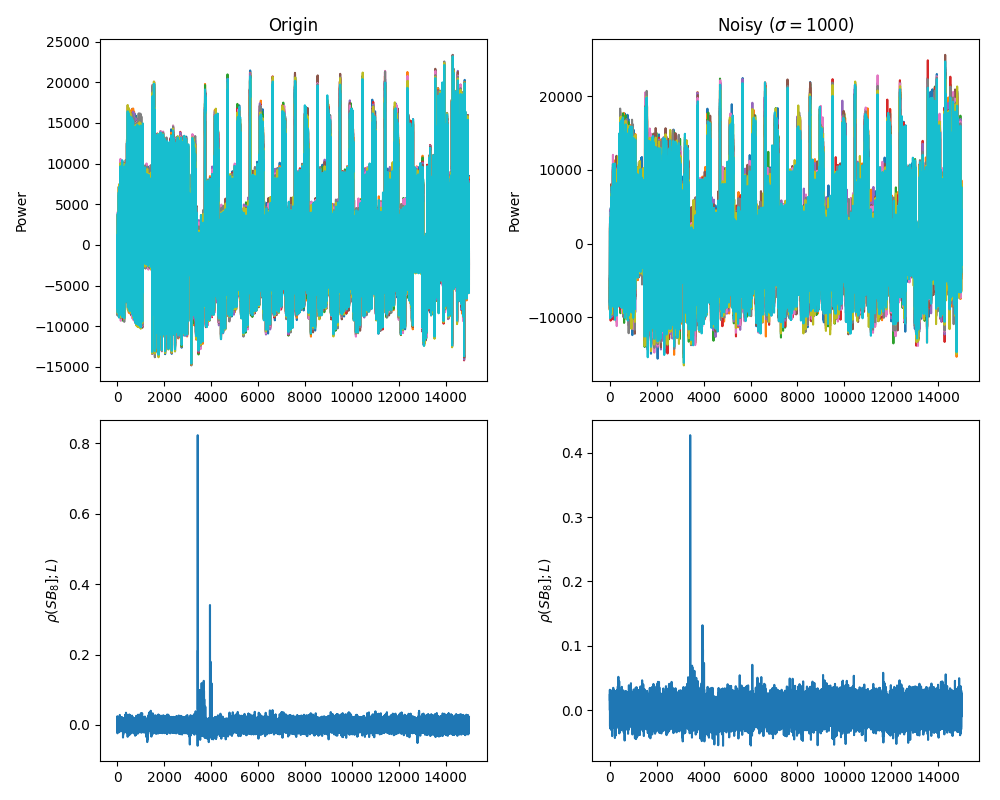

In [32]:
from utils_scale import utils_plot
%matplotlib widget
import matplotlib.pyplot as plt 

# Byte index to plot
# TODO: modify this value
bindex = 8

# Plot the figure
utils_plot.display_noisy_correlation(corr_noisy, corr_origin, dataset_noisy['traces'], traces_origin, dataset_noisy["ks"][0], bindex, noise_std)

The following code can be used to verify your hypotheses: in particular, it runs several CPA using different number of traces and different noise levels, and display the amount of bytes recovered for each case (i.e., each curve represents a different noise level). Does it corresponds to what you were expecting?

Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.66s/it]


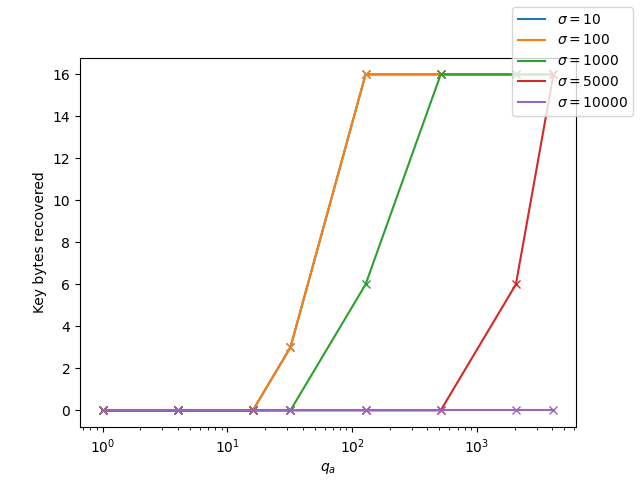

In [33]:
from utils_scale import utils_files, utils_cpa
%matplotlib widget
import matplotlib.pyplot as plt

# Dataset to use
ds_filepath = utils_files.VALIDATION_DS[0]

# TODO: edit here
# The standard deviation to use
stds = [10, 100, 1000, 5000, 10000]

# TODO: edit here
# The attack complexity to use
qas = [1, 4, 16, 32, 128, 512, 2048, 4096]

utils_cpa.cpa_with_exploration(ds_filepath, utils_cpa.scalib_complete_cpa_out_sbox, std=stds, qa=qas)

How do you explain this phenomenon? Try to find a theoritical reason behind that. To get some intuition, the following script display the different numerical values involved in the computation of the correlation. 

- *hint: how do the correlation numerator and denominator evolve with the noise? Which one has a bigger impact? Is it expected?*

In [22]:
from utils_scale import utils_files, utils_cpa
%matplotlib widget
import matplotlib.pyplot as plt

# Dataset to use
ds_filepath = utils_files.VALIDATION_DS[0]

# TODO: edit here
# The standard deviation to use
stds = [0,10, 100, 1000, 5000, 10000]

# TODO: edit here:
bindex=8

utils_cpa.cpa_parts_exploration(ds_filepath, bindex, std=stds)

Using time index 3428 [corr. max 0.8227461403511397]
---> For std_noise = 0
correlation:0.8227461403511397
covariance:700.9333829879761
std_model:1.3984538668734974
std_traces:602.4887110724446

---> For std_noise = 10
correlation:0.8227330444308607
covariance:700.7503023259567
std_model:1.3984538668734974
std_traces:602.3433941725515

---> For std_noise = 100
correlation:0.8123753934039745
covariance:699.1025763677826
std_model:1.3984538668734974
std_traces:608.5873965971563

---> For std_noise = 1000
correlation:0.4153985126600895
covariance:682.6253167860422
std_model:1.3984538668734974
std_traces:1162.1239475133978

---> For std_noise = 5000
correlation:0.085168245414506
covariance:609.3930519783066
std_model:1.3984538668734974
std_traces:5060.10702192393

---> For std_noise = 10000
correlation:0.03191042154822079
covariance:517.8527209686372
std_model:1.3984538668734974
std_traces:10079.997856417602



## Dataset quality and measurement setup engineering problems
So far, we've seen the impact that Guassian noise can have on correlation values, and therefore on the complexity required for a successful CPA attack. This type of noise can typically be traced back to the additive white noise affecting any electronic device. 

Additionally, this section present other mechanism that may impact the quality of measurement, potentially making these more difficult (or infeasible) to exploit. In particular, you will manipulate different datasets that are affected with contaminations that typically occur with a lack of precaution or with a measurement setup of poor quality.

To evaluate the effects more objectively, we suggest you compare the correlation metrics between a standard dataset and an uncontaminated dataset, as allowed by the `utils_cpa.scalib_corr_traces` function you've already used.

### Clipping
In this first case, we'll look at the effects of clipping. Clipping typically occurs as a result of a poorly configured vertical range (i.e., too small) of the oscilloscope, leading to a significant reduction in measurement resolution. As an example, consider a circuit with a current consumption such that the voltage across the measured shunt resistor oscillates between +-50mV. In this configuration, an oscilloscope configured with a range of +-20mV will saturate at the same value as soon as the instantaneous voltage exceeds the configured threshold. Saturated values can therefore no longer be used as a source of discriminating information, significantly (if not totally) reducing measurement quality.

See for yourself! Try to run the following template and observe the effect of clipping. In particular:

- What do you observe visually compared to a unaffected dataset?
- How does it change when you modify `clip_mv`?
- What is the impact on the correlation metric? What do you expect for the CPA attack complexity?
- Would the conclusion be the same for other intermediate variables than the Sbox output? (*hint: consider other locations in the trace*)

In [42]:
from utils_scale import utils_cpa, utils_files
# range used when clipping occur (50mV used for a correct acquiision)
# TODO: modify this value
clip_mv = 20

# Load the noisy version of the dataset
dataset_noisy = utils_cpa.load_clipped_dataset(utils_files.VALIDATION_DS[0], mv_clip=clip_mv)
# Load the noise-free traces
traces_origin = utils_files.load_dataset(utils_files.VALIDATION_DS[0])['traces']

# Compute the correlation associated to both cases
models = utils_cpa.model_HW_outSB(dataset_noisy['pts'].shape[1], traces_origin.shape[1])
corr_noisy = utils_cpa.scalib_corr_traces(dataset_noisy['traces'], dataset_noisy['pts'], models)
corr_origin= utils_cpa.scalib_corr_traces(traces_origin, dataset_noisy['pts'], models)

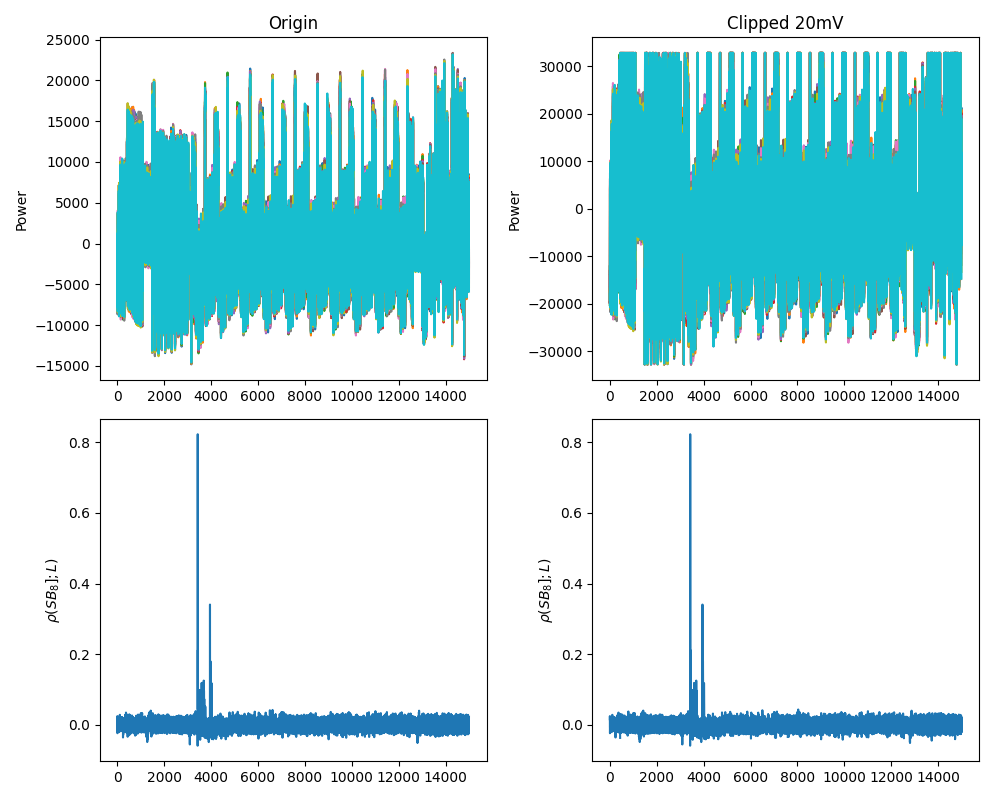

In [43]:
from utils_scale import utils_plot
%matplotlib widget
import matplotlib.pyplot as plt 

# Byte index to plot
# TODO: modify this value
bindex = 8

# Plot the figure
utils_plot.display_clipped_correlation(corr_noisy, corr_origin, dataset_noisy['traces'], traces_origin, dataset_noisy["ks"][0], bindex, clip_mv)

### Desynchronization

Trace desynchronization is an effect that occurs when the measurements of each execution are not aligned in time. Without going into too much detail, this kind of effect is often the result of a missing or incorrect trigger signal. In laboratories with a controlled environment, it is relatively easy to obtain a dedicated trigger signal. However, this is not necessarily the case in practical attack environments, where we are forced to rely on re-alignment euristics (such as maximum correlation with an identifiable pattern). However, the presence of a trigger signal does not guarantee that there is no misalignment: desynchronization remains possible, for example, if the phase shift between the target clock frequency and the sampling frequency varies. Generally speaking, it's good practice to use a sampling frequency that's a multiple of the measured clock frequency.

See for yourself! Try to run the following template and observe the effect of de-sync. In particular:

- What do you observe visually compared to a unaffected dataset?
- What is the impact on the correlation metric? What do you expect for the CPA attack complexity?
- Would the conclusion be the same for other intermediate variables than  the Sbox output? (*hint: consider other locations in the trace*)

In [25]:
from utils_scale import utils_cpa, utils_files
# std of the misalignement (in amount of samples)
# TODO: modify this value
std_misalign = 5

# Load the noisy version of the dataset
dataset_noisy = utils_cpa.load_misalign_dataset(utils_files.VALIDATION_DS[0], std_mis=std_misalign)
# Load the noise-free traces
traces_origin = utils_cpa.load_misalign_dataset_ref(utils_files.VALIDATION_DS[0])['traces']

# Compute the correlation associated to both cases
models = utils_cpa.model_HW_outSB(dataset_noisy['pts'].shape[1], traces_origin.shape[1])
corr_noisy = utils_cpa.scalib_corr_traces(dataset_noisy['traces'], dataset_noisy['pts'], models)
corr_origin= utils_cpa.scalib_corr_traces(traces_origin, dataset_noisy['pts'], models)

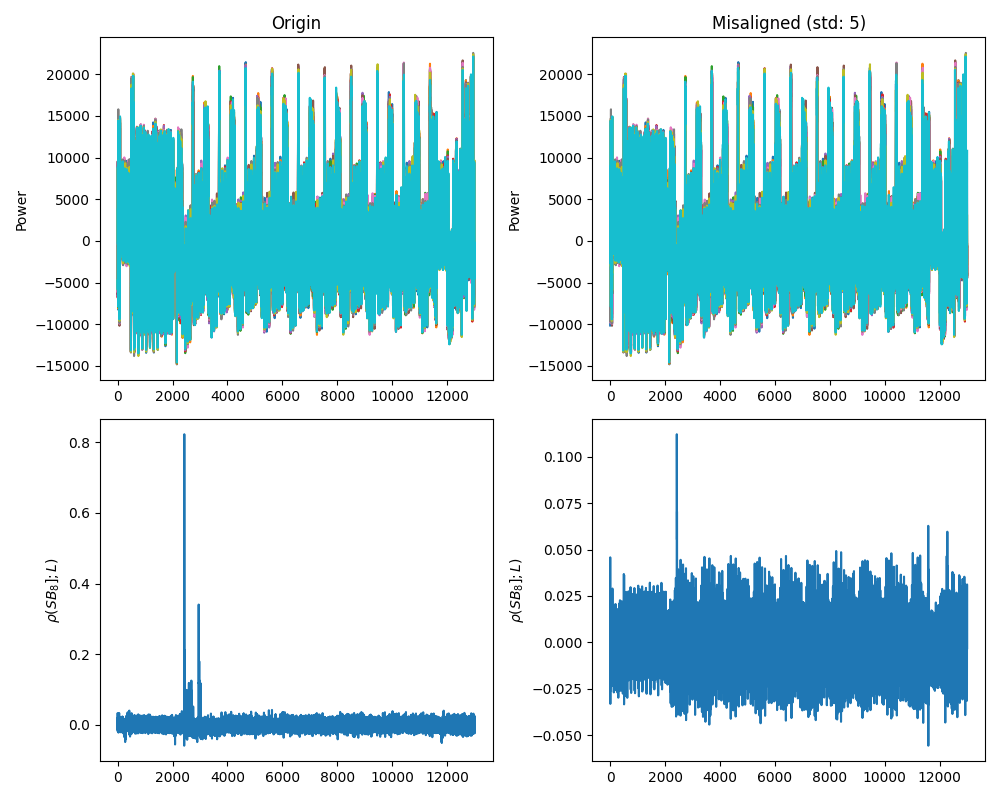

In [26]:
from utils_scale import utils_plot
%matplotlib widget
import matplotlib.pyplot as plt 

# Byte index to plot
# TODO: modify this value
bindex = 8

# Plot the figure
utils_plot.display_misaligned_correlation(corr_noisy, corr_origin, dataset_noisy['traces'], traces_origin, dataset_noisy["ks"][0], bindex, std_misalign)

### A quiet threat: temporal average.

The last example we'll cover concerns time-averaging shifts. It's important to remember that measurement setups are sensitive to the surrounding environment, and are therefore subject to physical effects that can be subtle if not properly considered and controlled. A typical example is temperature variations in the surroundings of the measurement setup. If these are slow or of low intensity, and the acquisition campaign lasts a long time, a visual inspection of a small part of the measured traces may be insufficient to pinpoint the problem that span during the full acquisition campaign.

Similarly to the other, use the following template in order to see the effect of the temporal shift. 

In [27]:
from utils_scale import utils_cpa, utils_files

# Load the noisy version of the dataset
dataset_noisy = utils_cpa.load_DCshift_dataset(utils_files.VALIDATION_DS[0], shift_mv=2.5)
# Load the noise-free traces
traces_origin = utils_files.load_dataset(utils_files.VALIDATION_DS[0])['traces']

# Compute the correlation associated to both cases
models = utils_cpa.model_HW_outSB(dataset_noisy['pts'].shape[1], traces_origin.shape[1])
corr_noisy = utils_cpa.scalib_corr_traces(dataset_noisy['traces'], dataset_noisy['pts'],models)
corr_origin= utils_cpa.scalib_corr_traces(traces_origin, dataset_noisy['pts'],models)

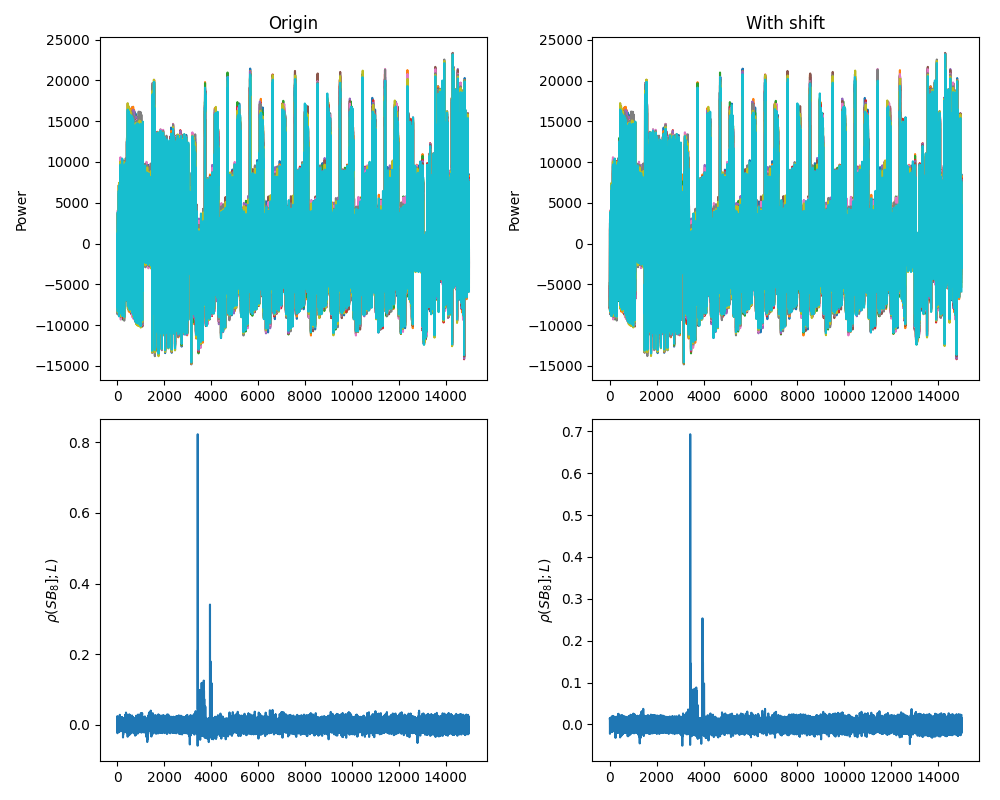

In [28]:
from utils_scale import utils_plot
%matplotlib widget
import matplotlib.pyplot as plt 

# Byte index to plot
# TODO: modify this value
bindex = 8

# Plot the figure
utils_plot.display_two_correlations(corr_noisy, corr_origin, dataset_noisy['traces'], traces_origin, dataset_noisy["ks"][0], bindex, "With shift")

Adittionally, the following script allows you see the time average within the dataset, for successive chunks of fixed size (which should highlight the problem more). In addition to the shift, do you notice anything else special?

*hint: the full dataset has been acquired in different chunks of 256 traces. Between these, the device had a small idle time where he was not perfomring any operation.*

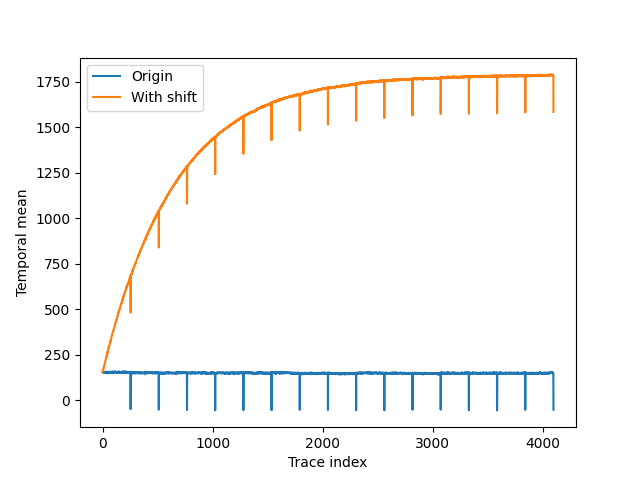

In [29]:
import numpy as np

def plot_temporal_average(traces_set, labels):
    assert len(traces_set)==len(labels)
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    for i, t in enumerate(traces_set):
        temp_mean = np.mean(t,axis=1)
        ax.plot(temp_mean, label=labels[i])
        ax.set_ylabel("Temporal mean")
        ax.set_xlabel("Trace index")
    plt.legend()
    plt.show()


plot_temporal_average(
    [traces_origin,dataset_noisy['traces']],
    ["Origin", "With shift"])


### Going further: the HW model limitations

If you follow correctly, you remeber that the correlation metrics we've computed so far are based solely using leakage Hamming Weight model assumption. Although it seems somewhat relevant, it's worth asking whether the Hamming weight hyptohesis holds up in practice.

In order to answer this question, the following code displays the scatter plot obtained with, on the one hand, the measurement point resulting in a maximum correlation (on the x-axis) and, on the other hand, the HW model of the latter (on the y-axis) for the 256 different possible classes with a fixed Sbox output byte. 

From what you observe, what can you conclude on the quality of the HW model? 

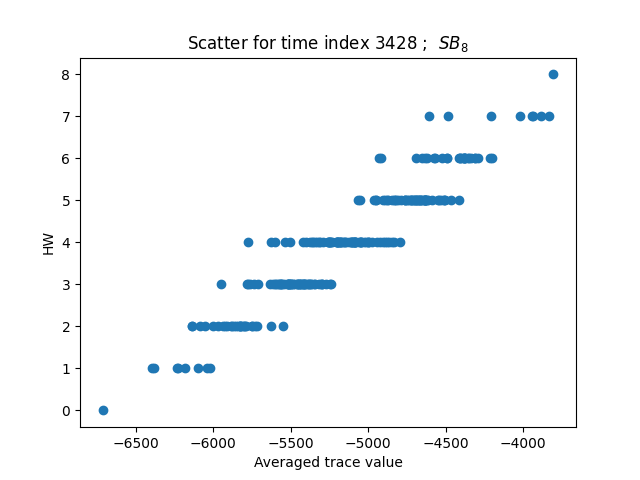

In [30]:
from utils_scale import utils_plot, utils_files

# Load the dataset with all random inputs
dataset = utils_files.load_dataset(utils_files.VALIDATION_DS[0])

# TODO: change this parameter
bindex = 8
utils_cpa.scatter_HW_mean(dataset, bindex)

In the following sessions, we'll show you how to improve the latter through a profiling phase. This additional step 
enables the leakage model of the device to be estimated more accurately, and thus enables more efficient plates to be assembled (i.e., requiring less complex attacks) at the cost of a more or less complex training phase, depending on the models created.